# 1. Image Fundamentals

In [49]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def mse(A, B, ax=None):
    '''
    ax = 0: the average is performed along the row, for each column, returning an array
    ax = 1: the average is performed along the column, for each row, returning an array
    ax = None: the average is performed element-wise along the array, returning a scalar value
    '''
    return ((A - B)**2).mean(axis=ax)

## 1.1. Geometric Transformation

**1.1.1. Suppose you want to make a panoramic picture of a wide landscape out of two separately captured pictures with
a certain overlap. Propose and implement an algorithm for stitching up the two images to make a panorama. List
the steps involved; Also, discuss and display the results (Test image Car1&2).**

**1.1.2. Write a program that implements rotation (with interpolation) of an image by a certain angle (30° , 45° , 80° ),
and apply it to Elaine image. The rotation center should be the image center.**

In [52]:
src_path = r'./Images/1/Elaine.bmp'
src = cv2.imread(src_path, cv2.IMREAD_GRAYSCALE)

In [53]:
def deg_to_rad(angle):
    return angle * np.pi / 180

In [54]:
def set_dst_size(src_shape, angle):
    dst_width = dst_height = None
    height, width = src_shape
    theta = deg_to_rad(angle)
    if theta <= np.pi / 2:
        dst_width = width * np.cos(theta) + height * np.sin(theta)
        dst_height = width * np.sin(theta) + height * np.cos(theta)
    else:
        dst_width = height * np.cos(theta - np.pi / 2) + width * np.sin(theta - np.pi / 2)
        dst_height = height * np.sin(theta - np.pi / 2) + width * np.cos(theta - np.pi / 2)
    
    return int(dst_height), int(dst_width)

In [55]:
def get_rotation_mtrix_2D(center_coord, rotation_angle = 0.0, scale = 1.0):
    
    center_x, center_y = center_coord
    theta = deg_to_rad(rotation_angle)
    
    return np.array([
        [scale * np.cos(theta), - scale * np.sin(theta), (1 - scale * np.cos(theta)) * center_x + scale * np.sin(theta) * center_y],
        [scale * np.sin(theta), scale * np.cos(theta), - scale * np.sin(theta) * center_x + (1 - scale * np.cos(theta)) * center_y]
    ])

In [65]:
def bilinear_interpolation(img, target_pixel):

    '''coefficients of interpolation'''
    a = b = c = d = None

    '''get coordination of pixel which should be interpolated'''
    x = target_pixel[0]
    y = target_pixel[1]

    '''get coordination and intensity of adjacent pixels '''
    top_left = img[x - 1][y - 1]
    top_left_x = x - 1
    top_left_y = y - 1

    top_right = img[x - 1][y + 1]
    top_right_x = x - 1
    top_right_y = y + 1

    down_right = img[x + 1][y + 1]
    down_right_x = x + 1
    down_right_y = y + 1

    down_left = img[x + 1][y - 1]
    down_left_x = x + 1
    down_left_y = y - 1

    '''matrix A, matrix of adjacent pixels coordination'''
    A = np.array([[top_left_x, top_left_y, top_left_x * top_left_y, 1]
            ,[top_right_x, top_right_y, top_right_x * top_right_y, 1]
            ,[down_right_x, down_right_y, down_right_x * down_right_y, 1]
            ,[down_left_x, down_left_y, down_left_x * down_left_y, 1]])

    '''matrix B, matrix of adjacent pixels intensity'''
    B = np.array([top_left, top_right, down_right, down_left])

    '''solve the linear equation to get the coefficients'''
    X = np.linalg.solve(A,B)

    a, b, c, d = X[0], X[1], X[2], X[3]

    '''return calculated intensity for target pixel'''
    return a * x + b * y + c * x * y + d

In [57]:
def warpAffine(src, rotation_mtrix, dst_size):

    dst = np.zeros(dst_size, dtype=np.uint8)
    height, width = src.shape
    dst_height, dst_width = dst_size

    '''loop over source image to calculate the affine transform'''
    
    for x in range(height):
        for y in range(width):
            u = int(rotation_mtrix[0, 0] * x + rotation_mtrix[0, 1] * y + rotation_mtrix[0, 2])
            v = int(rotation_mtrix[1, 0] * x + rotation_mtrix[1, 1] * y + rotation_mtrix[1, 2])
            '''if destination coordinate doesn't exceed the dimension of destination image'''
            if 0 <= u < dst_height and 0 <= v < dst_width:
                dst[u, v] = src[x, y]

    '''loop over destination image to interpolate(bilinear interpolation here)'''
    final_image = np.zeros(dst_size, dtype=np.uint8)
    for i in range(dst_height - 1):
        for j in range(dst_width - 1):
            '''ignore the frame of image(four tapes around the image) for interpolation'''
            if i != 0 or i != dst_height - 2 or j != 0 or j != dst_width - 2:
                final_image[i, j] = bilinear_interpolation(dst, (i, j))
                
    return final_image

In [58]:
def rotate(src, angle):
    height, width = src.shape
    dst_height, dst_width = set_dst_size((height, width), angle)
    center_x, center_y = (width / 2, height / 2)
    rotation_mtrix = get_rotation_mtrix_2D((center_x, center_y), angle)
    rotation_mtrix[0, 2] += (dst_width / 2) - center_x
    rotation_mtrix[1, 2] += (dst_height / 2) - center_y
    dst = warpAffine(src, rotation_mtrix, (dst_height, dst_width))
    return dst

In [66]:
elaine_30_rotated = rotate(src, 30)

In [67]:
elaine_45_rotated = rotate(src, 45)

In [68]:
elaine_80_rotated = rotate(src, 80)

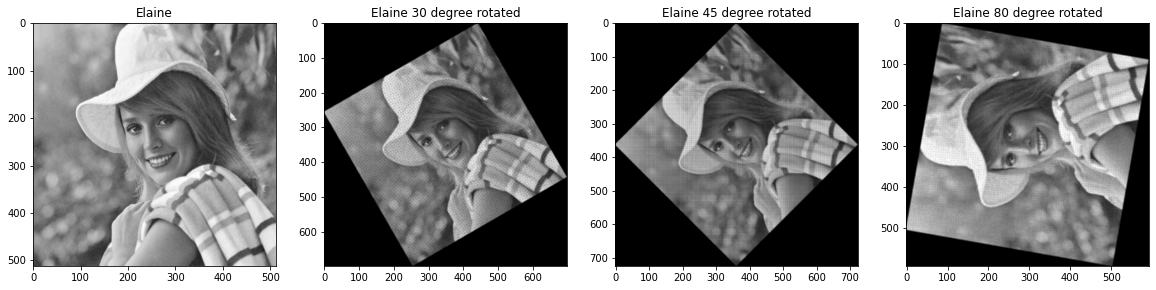

In [69]:
plt.figure(figsize=(20,10))

plt.subplot(1, 4, 1)
plt.title("Elaine")
plt.imshow(src, cmap='gray')

plt.subplot(1, 4, 2)
plt.title("Elaine 30 degree rotated")
plt.imshow(elaine_30_rotated, cmap='gray')

plt.subplot(1, 4, 3)
plt.title("Elaine 45 degree rotated")
plt.imshow(elaine_45_rotated, cmap='gray')

plt.subplot(1, 4, 4)
plt.title("Elaine 80 degree rotated")
plt.imshow(elaine_80_rotated, cmap='gray')

In [34]:
cv2.imwrite('./Output Images/1/elaine_30_rotated.bmp', elaine_30_rotated)
cv2.imwrite('./Output Images/1/elaine_45_rotated.bmp', elaine_45_rotated)
cv2.imwrite('./Output Images/1/elaine_80_rotated.bmp', elaine_80_rotated)

True

## 1.2. Quantization & Interpolation

**1.2.1. For two cases as without and with histogram equalization (uniform histogram), display the quantized image in
(8, 16, 32, 64, 128) Levels and its histograms. Also, the optimum mean square error obtained for each case.
Discuss and report the results for the gray Barbara image. It should be noted, you can use rgb2gray, histeq and
immse functions for this problem.**

In [70]:
def calc_step(target_level):
    return math.ceil(255 / target_level)

In [71]:
def quantize(src, target_level):    
    bins = np.linspace(0, src.max(), target_level)
    image = np.digitize(src, bins)
    image = (np.vectorize(bins.tolist().__getitem__)(image-1).astype(int))
    return image

In [72]:
def calculate_histogram(src):

    '''this function computes the histogram of a gray-scale image.'''

    height, width = src.shape
    src_flattened = src.flatten()
    num_pixels = len(src_flattened)
    intensities = np.linspace(start=0, stop=255, num=256, endpoint=True, dtype=int)
    
    frequencies = np.zeros(256, dtype=np.uint16)

    for i in range(num_pixels):
        frequencies[src_flattened[i]] += 1
    
    return intensities, frequencies

In [73]:
src_path = r'./Images/1/Barbara.bmp'
src = cv2.imread(src_path, cv2.IMREAD_GRAYSCALE)

In [74]:
src_8_level_quantized = quantize(src, 8)
src_16_level_quantized = quantize(src, 16)
src_32_level_quantized = quantize(src, 32)
src_64_level_quantized = quantize(src, 64)
src_128_level_quantized = quantize(src, 128)

In [48]:
cv2.imwrite('./Output Images/1/Barbara_8_Levels.jpg', src_8_level_quantized)
cv2.imwrite('./Output Images/1/Barbara_16_Levels.jpg', src_16_level_quantized)
cv2.imwrite('./Output Images/1/Barbara_32_Levels.jpg', src_32_level_quantized)
cv2.imwrite('./Output Images/1/Barbara_64_Levels.jpg', src_64_level_quantized)
cv2.imwrite('./Output Images/1/Barbara_128_Levels.jpg', src_128_level_quantized)

True

In [75]:
intensities, src_8_level_quantized_histogram = calculate_histogram(src_8_level_quantized)
intensities, src_16_level_quantized_histogram = calculate_histogram(src_16_level_quantized)
intensities, src_32_level_quantized_histogram = calculate_histogram(src_32_level_quantized)
intensities, src_64_level_quantized_histogram = calculate_histogram(src_64_level_quantized)
intensities, src_128_level_quantized_histogram = calculate_histogram(src_128_level_quantized)

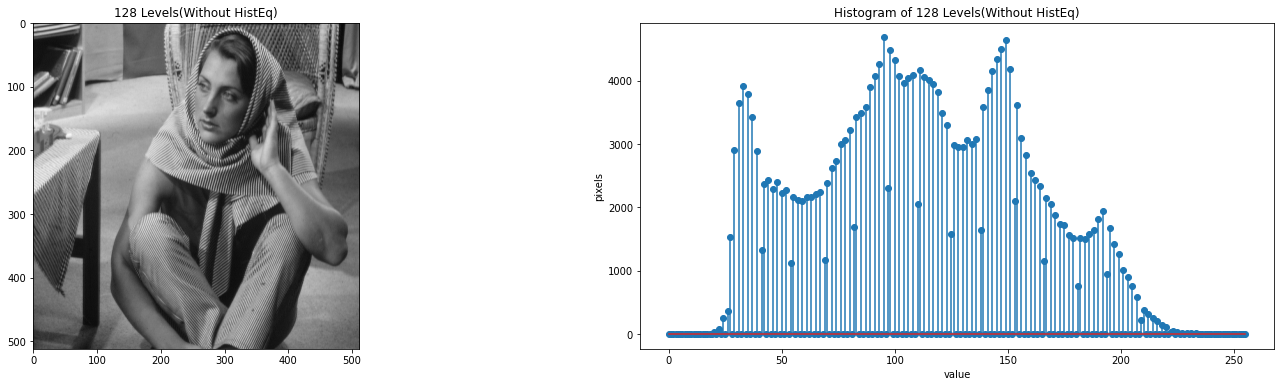

In [76]:
plt.figure(figsize=(25,6))

plt.subplot(1, 2, 1)
plt.title("128 Levels(Without HistEq)")
plt.imshow(src_128_level_quantized, cmap='gray')

plt.subplot(1, 2, 2)
plt.stem(intensities, src_128_level_quantized_histogram)
plt.title("Histogram of 128 Levels(Without HistEq)")
plt.xlabel("value")
plt.ylabel("pixels")

plt.show()

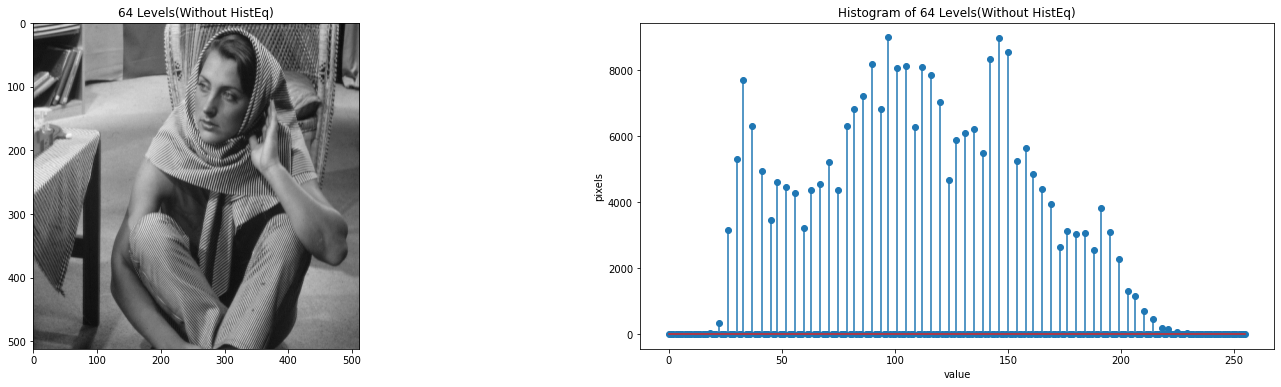

In [77]:
plt.figure(figsize=(25,6))

plt.subplot(1, 2, 1)
plt.title("64 Levels(Without HistEq)")
plt.imshow(src_64_level_quantized, cmap='gray')

plt.subplot(1, 2, 2)
plt.stem(intensities, src_64_level_quantized_histogram)
plt.title("Histogram of 64 Levels(Without HistEq)")
plt.xlabel("value")
plt.ylabel("pixels")

plt.show()

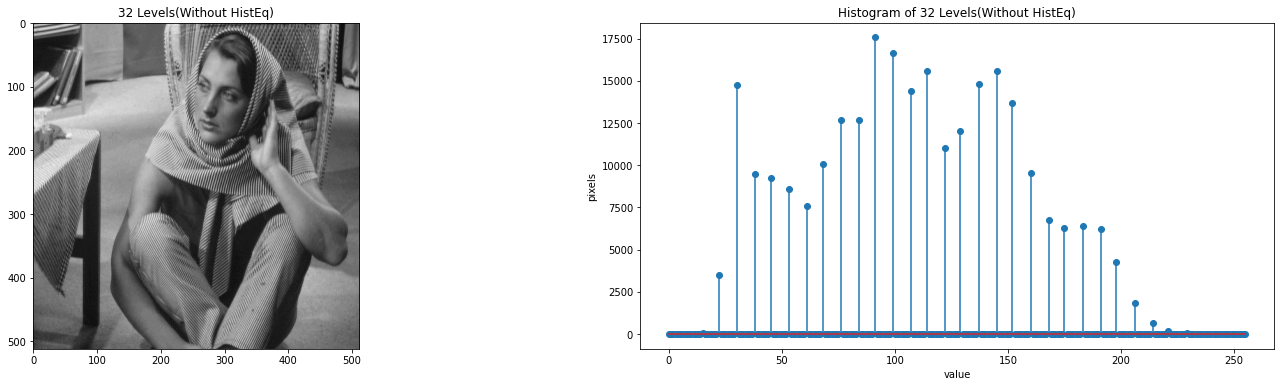

In [78]:
plt.figure(figsize=(25,6))

plt.subplot(1, 2, 1)
plt.title("32 Levels(Without HistEq)")
plt.imshow(src_32_level_quantized, cmap='gray')

plt.subplot(1, 2, 2)
plt.stem(intensities, src_32_level_quantized_histogram)
plt.title("Histogram of 32 Levels(Without HistEq)")
plt.xlabel("value")
plt.ylabel("pixels")

plt.show()

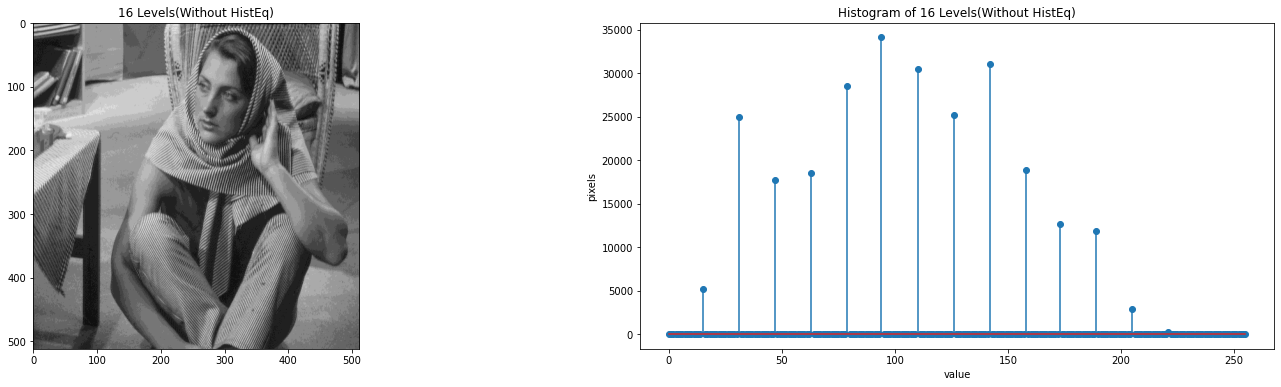

In [79]:
plt.figure(figsize=(25,6))

plt.subplot(1, 2, 1)
plt.title("16 Levels(Without HistEq)")
plt.imshow(src_16_level_quantized, cmap='gray')

plt.subplot(1, 2, 2)
plt.stem(intensities, src_16_level_quantized_histogram)
plt.title("Histogram of 16 Levels(Without HistEq)")
plt.xlabel("value")
plt.ylabel("pixels")

plt.show()

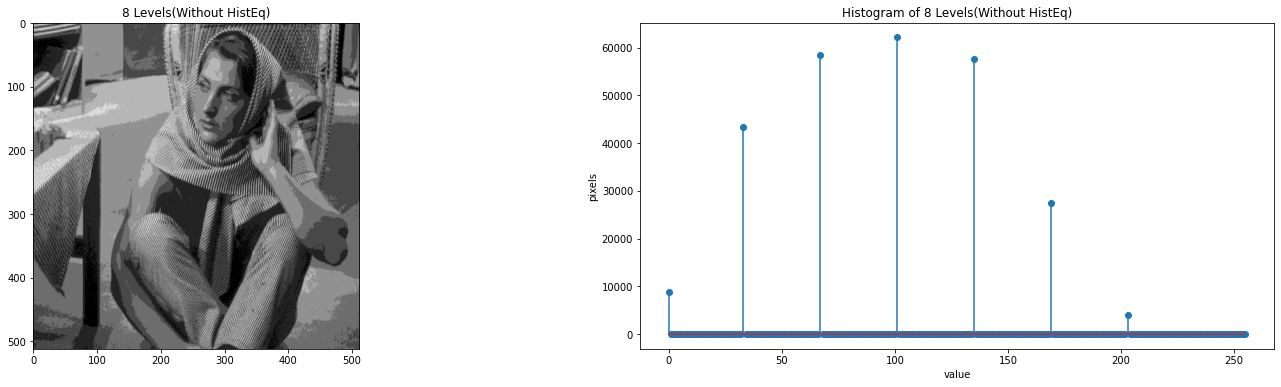

In [80]:
plt.figure(figsize=(25,6))

plt.subplot(1, 2, 1)
plt.title("8 Levels(Without HistEq)")
plt.imshow(src_8_level_quantized, cmap='gray')

plt.subplot(1, 2, 2)
plt.stem(intensities, src_8_level_quantized_histogram)
plt.title("Histogram of 8 Levels(Without HistEq)")
plt.xlabel("value")
plt.ylabel("pixels")

plt.show()

In [81]:
mse8 = mse(src, src_8_level_quantized)
mse16 = mse(src, src_16_level_quantized)
mse32 = mse(src, src_32_level_quantized)
mse64 = mse(src, src_64_level_quantized)
mse128 = mse(src, src_128_level_quantized)

In [82]:
src_equalized = cv2.equalizeHist(src)

In [83]:
src_equalized_8_level_quantized = quantize(src_equalized, 8)
src_equalized_16_level_quantized = quantize(src_equalized, 16)
src_equalized_32_level_quantized = quantize(src_equalized, 32)
src_equalized_64_level_quantized = quantize(src_equalized, 64)
src_equalized_128_level_quantized = quantize(src_equalized, 128)

In [58]:
cv2.imwrite('./Output Images/1/Barbara_Equalized_8_Levels.jpg', src_equalized_8_level_quantized)
cv2.imwrite('./Output Images/1/Barbara_Equalized_16_Levels.jpg', src_equalized_16_level_quantized)
cv2.imwrite('./Output Images/1/Barbara_Equalized_32_Levels.jpg', src_equalized_32_level_quantized)
cv2.imwrite('./Output Images/1/Barbara_Equalized_64_Levels.jpg', src_equalized_64_level_quantized)
cv2.imwrite('./Output Images/1/Barbara_Equalized_128_Levels.jpg', src_equalized_128_level_quantized)

True

In [84]:
intensities, src_equalized_8_level_quantized_histogram = calculate_histogram(src_equalized_8_level_quantized)
intensities, src_equalized_16_level_quantized_histogram = calculate_histogram(src_equalized_16_level_quantized)
intensities, src_equalized_32_level_quantized_histogram = calculate_histogram(src_equalized_32_level_quantized)
intensities, src_equalized_64_level_quantized_histogram = calculate_histogram(src_equalized_64_level_quantized)
intensities, src_equalized_128_level_quantized_histogram = calculate_histogram(src_equalized_128_level_quantized)

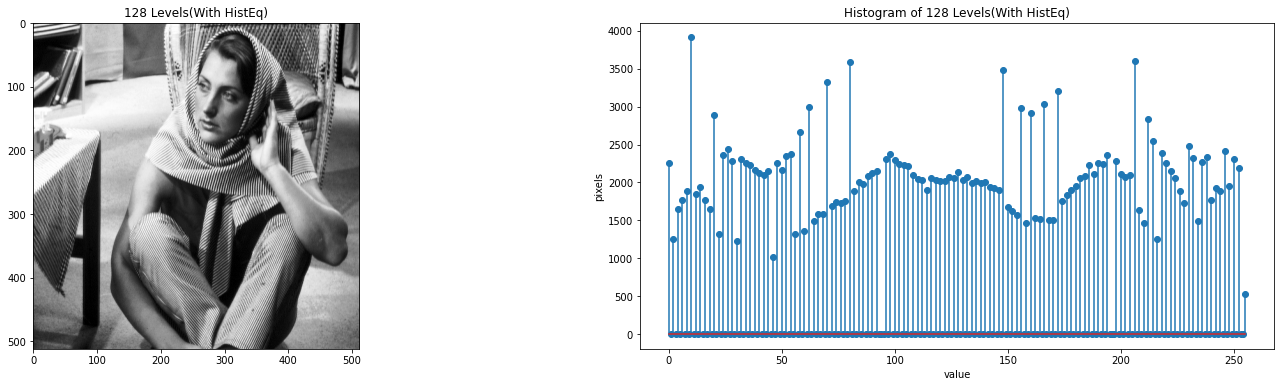

In [85]:
plt.figure(figsize=(25,6))

plt.subplot(1, 2, 1)
plt.title("128 Levels(With HistEq)")
plt.imshow(src_equalized_128_level_quantized, cmap='gray')

plt.subplot(1, 2, 2)
plt.stem(intensities, src_equalized_128_level_quantized_histogram)
plt.title("Histogram of 128 Levels(With HistEq)")
plt.xlabel("value")
plt.ylabel("pixels")

plt.show()

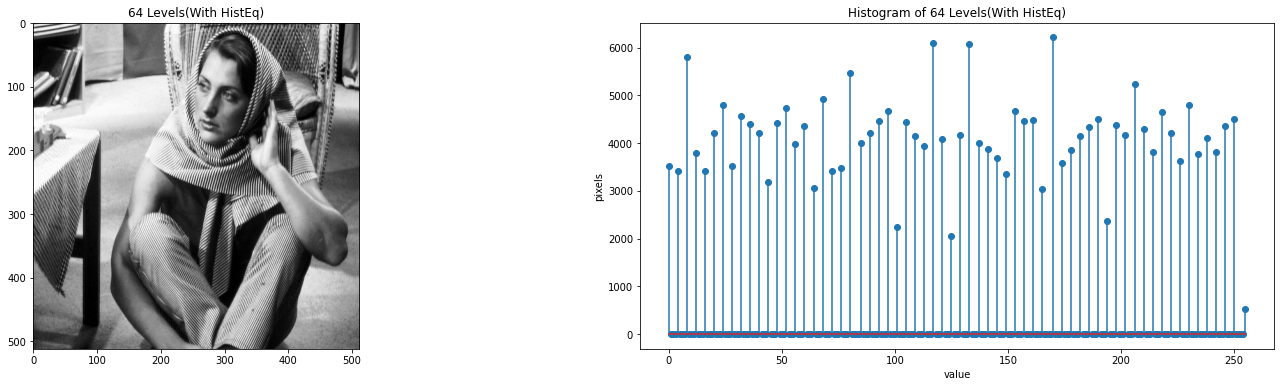

In [86]:
plt.figure(figsize=(25,6))

plt.subplot(1, 2, 1)
plt.title("64 Levels(With HistEq)")
plt.imshow(src_equalized_64_level_quantized, cmap='gray')

plt.subplot(1, 2, 2)
plt.stem(intensities, src_equalized_64_level_quantized_histogram)
plt.title("Histogram of 64 Levels(With HistEq)")
plt.xlabel("value")
plt.ylabel("pixels")

plt.show()

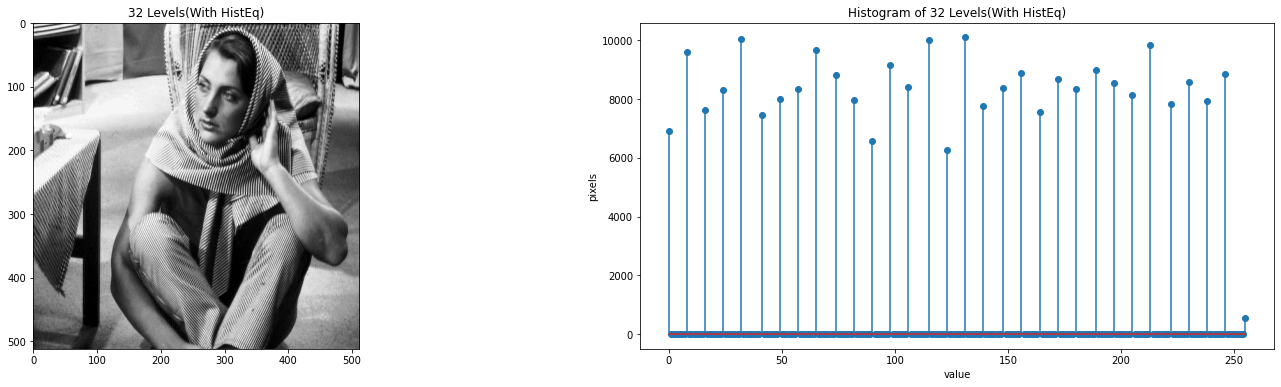

In [87]:
plt.figure(figsize=(25,6))

plt.subplot(1, 2, 1)
plt.title("32 Levels(With HistEq)")
plt.imshow(src_equalized_32_level_quantized, cmap='gray')

plt.subplot(1, 2, 2)
plt.stem(intensities, src_equalized_32_level_quantized_histogram)
plt.title("Histogram of 32 Levels(With HistEq)")
plt.xlabel("value")
plt.ylabel("pixels")

plt.show()

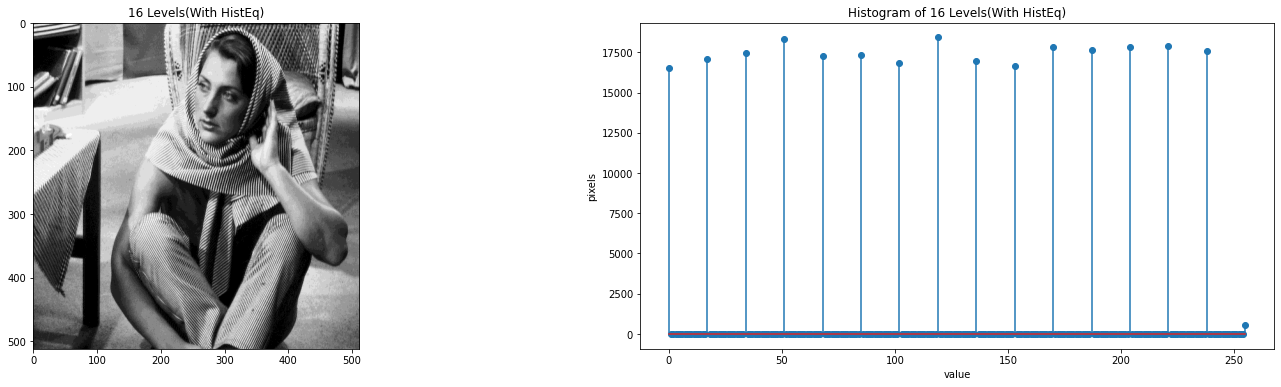

In [88]:
plt.figure(figsize=(25,6))

plt.subplot(1, 2, 1)
plt.title("16 Levels(With HistEq)")
plt.imshow(src_equalized_16_level_quantized, cmap='gray')

plt.subplot(1, 2, 2)
plt.stem(intensities, src_equalized_16_level_quantized_histogram)
plt.title("Histogram of 16 Levels(With HistEq)")
plt.xlabel("value")
plt.ylabel("pixels")

plt.show()

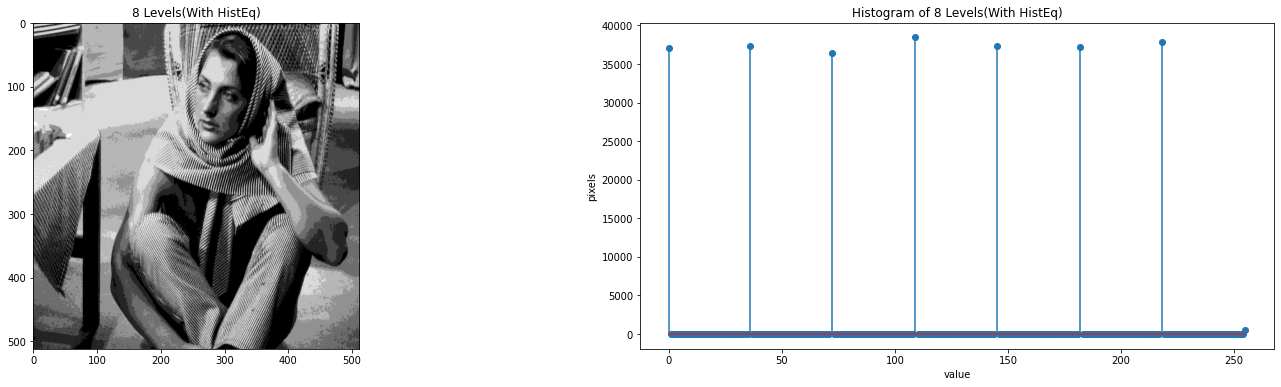

In [89]:
plt.figure(figsize=(25,6))

plt.subplot(1, 2, 1)
plt.title("8 Levels(With HistEq)")
plt.imshow(src_equalized_8_level_quantized, cmap='gray')

plt.subplot(1, 2, 2)
plt.stem(intensities, src_equalized_8_level_quantized_histogram)
plt.title("Histogram of 8 Levels(With HistEq)")
plt.xlabel("value")
plt.ylabel("pixels")

plt.show()

In [90]:
mse8_equalized = mse(src_equalized, src_equalized_8_level_quantized)
mse16_equalized = mse(src_equalized, src_equalized_16_level_quantized)
mse32_equalized = mse(src_equalized, src_equalized_32_level_quantized)
mse64_equalized = mse(src_equalized, src_equalized_64_level_quantized)
mse128_equalized = mse(src_equalized, src_equalized_128_level_quantized)

###### Report MSE

In [91]:
data = {'8 Levels': [mse8, mse8_equalized,],
        '16 Levels': [mse16, mse16_equalized],
        '32 Levels': [mse32, mse32_equalized],
        '64 Levels': [mse64, mse64_equalized],
        '128 Levels': [mse128, mse128_equalized]
        }

df = pd.DataFrame(data, index=['Without Histeq','With Histeq'])

df.head()

,8 Levels,16 Levels,32 Levels,64 Levels,128 Levels
Without Histeq,396.495762,87.221512,23.745785,6.759617,2.394012
With Histeq,458.052666,91.954182,25.511429,7.248894,2.514545


In [92]:
print("The optimum MSE for the unequalized image belongs to 128-Level image and it's value is: " + str(mse128))

The optimum MSE for the unequalized image belongs to 128-Level image and it's value is: 2.394012451171875


In [76]:
print("The optimum MSE for the equalized image belongs to 128-Level image and it's value is: " + str(mse128_equalized))

The optimum MSE for the equalized image belongs to 128-Level image and it's value is: 2.514545440673828


**1.2.2. Write a program which can, firstly, downsample an image by a factor of 2, with and without using the averaging
filter, and also, up-sample the previously downsampled images by a factor of 2, using the pixel replication and
bilinear interpolation methods, respectively. Display (zoom of image) and discuss the results obtained with
different methods for the Goldhill image. Note, you can use immse function for this problem.**

In [15]:
src_path = r'./Images/1/Goldhill.bmp'
src = cv2.imread(src_path, cv2.IMREAD_GRAYSCALE)

In [12]:
def downsample_by_remove_rows_and_columns(src):
    return src[::2, ::2]

In [17]:
def downsample_by_average_filter(src):
    height, width = src.shape
    dst_height, dst_width = (height // 2, width // 2)
    
    dst = np.zeros((dst_height, dst_width))
    
    for i in range(dst_height):
        for j in range(dst_width):
            block = src[2 * i: 2 * i + 2, 2 * j: 2 * j + 2]
            dst[i, j] = np.mean(block.flatten())
    
    return dst

In [16]:
row_column_removed_src = downsample_by_remove_rows_and_columns(src)

In [18]:
averaged_src = downsample_by_average_filter(src)

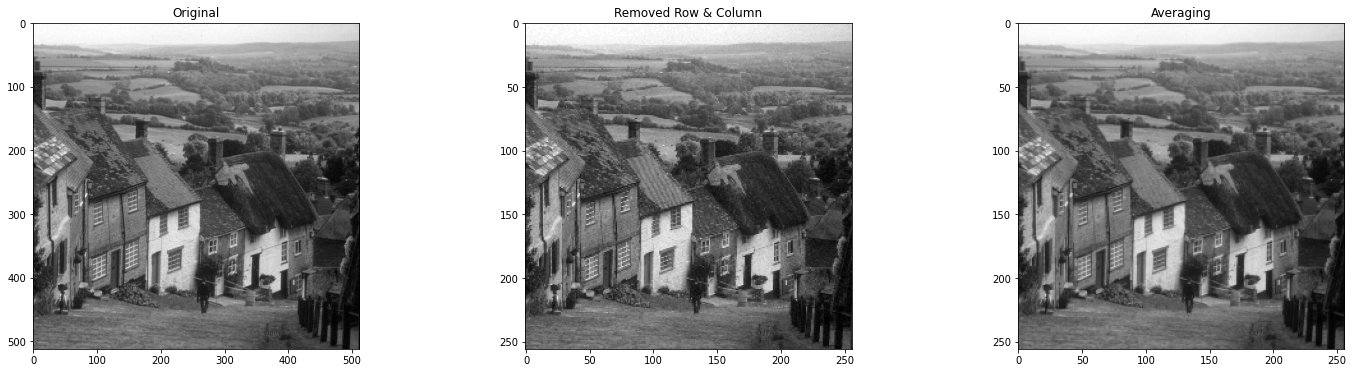

In [102]:
plt.figure(figsize=(25,6))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(src, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Downsampled(Removed Row & Column)")
plt.imshow(row_column_removed_src, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Downsampled(Averaging)")
plt.imshow(averaged_src, cmap='gray')

plt.show()

In [48]:
def upsample_by_pixel_replication(src):
    height, width = src.shape
    dst_height, dst_width = (height * 2, width * 2)
    dst = np.zeros((dst_height, dst_width), dtype=int)
    
    for i in range(0, dst_height-1, 2):
        for j in range(0, dst_width-1, 2):
            dst[i, j] = src[i//2][j//2]
    
    for i in range(1, dst_height-1, 2):
        for j in range(0, dst_width-1):
            dst[i:i+1, j] = dst[i-1, j]
    
    for i in range(0, dst_height-1):
        for j in range(1, dst_width-1, 2):
            dst[i, j:j+1] = dst[i, j-1]

    return dst

In [39]:
pixel_replicated_row_column_removed_src = upsample_by_pixel_replication(row_column_removed_src)

In [40]:
pixel_replicated_averaged_src = upsample_by_pixel_replication(averaged_src)

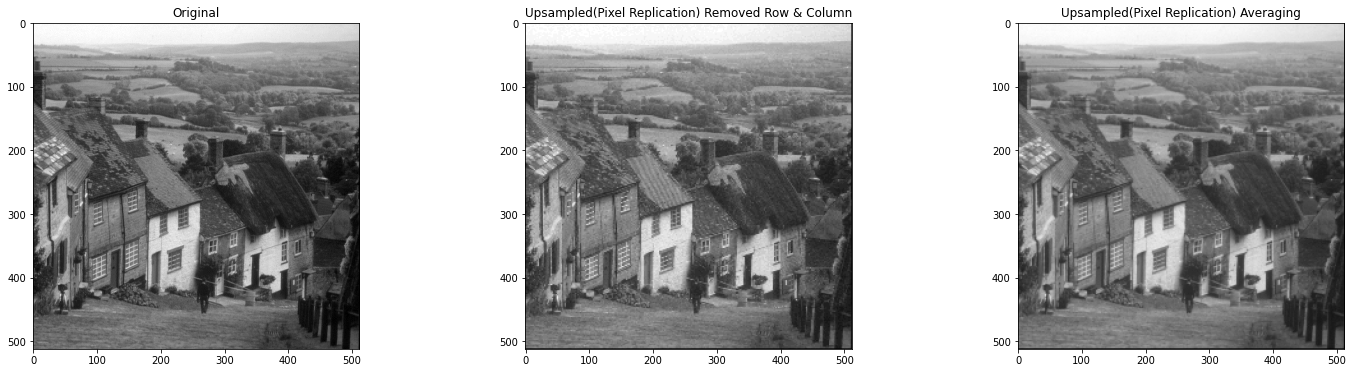

In [41]:
plt.figure(figsize=(25,6))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(src, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Upsampled(Pixel Replication) Removed Row & Column")
plt.imshow(pixel_replicated_row_column_removed_src, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Upsampled(Pixel Replication) Averaging")
plt.imshow(pixel_replicated_averaged_src, cmap='gray')

plt.show()

In [47]:
def bilinear_resize(src, dst_height, dst_width):
  
    height, width = src.shape

    resized = np.empty([dst_height, dst_width])

    x_ratio = float(width - 1) / (dst_width - 1) if dst_width > 1 else 0
    y_ratio = float(height - 1) / (dst_height - 1) if dst_height > 1 else 0

    for i in range(dst_height):
        for j in range(dst_width):

            x_l, y_l = math.floor(x_ratio * j), math.floor(y_ratio * i)
            x_h, y_h = math.ceil(x_ratio * j), math.ceil(y_ratio * i)

            x_weight = (x_ratio * j) - x_l
            y_weight = (y_ratio * i) - y_l

            a = src[y_l, x_l]
            b = src[y_l, x_h]
            c = src[y_h, x_l]
            d = src[y_h, x_h]

            pixel = a * (1 - x_weight) * (1 - y_weight) + b * x_weight * (1 - y_weight) + c * y_weight * (1 - x_weight) + d * x_weight * y_weight

            resized[i][j] = pixel

    return resized

In [43]:
bilinear_interpolated_row_column_removed_src = bilinear_resize(row_column_removed_src, 512, 512)

In [44]:
bilinear_interpolated_averaged_src = bilinear_resize(averaged_src, 512, 512)

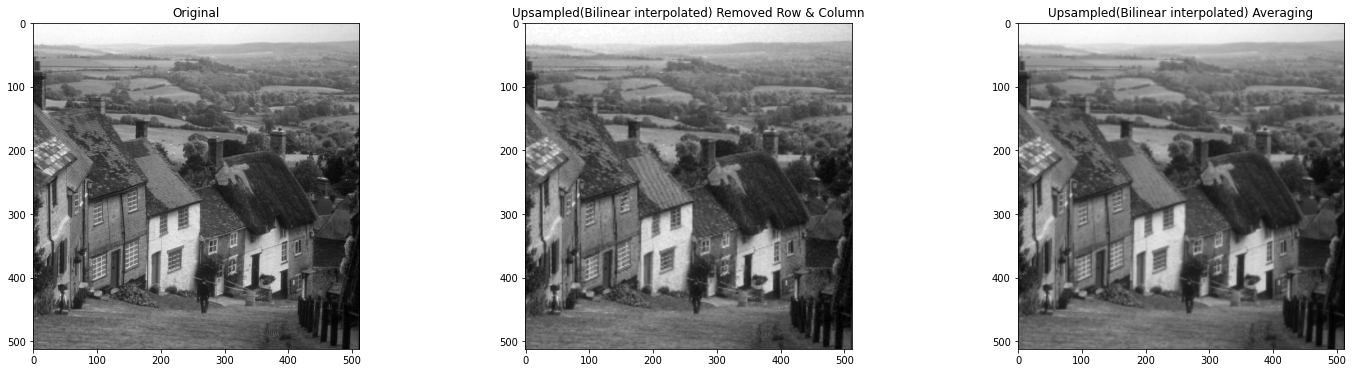

In [45]:
plt.figure(figsize=(25,6))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(src, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Upsampled(Bilinear interpolated) Removed Row & Column")
plt.imshow(bilinear_interpolated_row_column_removed_src, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Upsampled(Bilinear interpolated) Averaging")
plt.imshow(bilinear_interpolated_averaged_src, cmap='gray')

plt.show()

###### Report MSE

In [51]:
data = {'Pixel Replication': [mse(src, pixel_replicated_averaged_src), mse(src, pixel_replicated_row_column_removed_src)],
        'Bilinear Replication': [mse(src, bilinear_interpolated_averaged_src), mse(src, bilinear_interpolated_row_column_removed_src)]
        }

df = pd.DataFrame(data, index=['Averaging','Remove Row & Column'])

df.head()

,Pixel Replication,Bilinear Replication
Averaging,101.144058,67.571470
Remove Row & Column,167.987976,99.333318


## Resources

1. https://numpy.org/doc/stable/reference/generated/numpy.array.html
2. https://numpy.org/doc/stable/reference/generated/numpy.zeros_like.html
3. https://docs.opencv.org/4.5.3/d8/d6a/group__imgcodecs__flags.html
4. https://numpy.org/doc/stable/reference/generated/numpy.digitize.html
5. https://numpy.org/doc/stable/reference/generated/numpy.vectorize.html
6. https://stackoverflow.com/questions/16774849/mean-squared-error-in-numpy
7. https://medium.com/swlh/image-processing-with-python-digital-image-sampling-and-quantization-4d2c514e0f00
8. https://docs.opencv.org/3.4.15/d4/d1b/tutorial_histogram_equalization.html
9. https://www.tutorialspoint.com/downsampling-an-image-using-opencv
10. https://www.tutorialkart.com/opencv/python/opencv-python-resize-image/
11. https://stackoverflow.com/questions/10431919/downsampling-without-smoothing
12. https://stackoverflow.com/questions/46657423/rotated-image-coordinates-after-scipy-ndimage-interpolation-rotate
13. https://www.pythonpool.com/python-rotate-image/
14. https://iiif.io/api/annex/notes/rotation/
15. https://www.tutorialspoint.com/dip/Zooming_Methods.htm
16. https://www.geeksforgeeks.org/spatial-resolution-down-sampling-and-up-sampling-in-image-processing/
17. https://stackoverflow.com/questions/26638390/decrease-array-size-by-averaging-adjacent-values-with-numpy
18. https://chao-ji.github.io/jekyll/update/2018/07/19/BilinearResize.html